In [1]:
%pip install -qU \
    langgraph==0.2.4 \
    langchain-openai==0.1.22

Note: you may need to restart the kernel to use updated packages.


In [2]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [4]:
from langchain_core.tools import tool


@tool("website_schema_validator_tool")
def website_schema_validator_tool(website_schema: str = None) -> bool:
    """
    Validate a website schema

    Args:
    schema (str): The website schema to validate

    Returns:
    bool: Whether the schema is valid
    """
    return True if website_schema else False

In [55]:
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.pydantic_v1 import BaseModel, Field, ValidationError


class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous")


class AnswerQuestion(BaseModel):
    """Answer the question. Provide an answer, reflection, and then follow up with search queries to improve the answer."""

    answer: str = Field(description="~250 word detailed answer to the question.")
    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    search_queries: list[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )


class ResponderWithRetries:
    def __init__(self, runnable, validator, name=""):
        self.runnable = runnable
        self.validator = validator
        self.name = name

    def respond(self, state):
        response = []
        for attempt in range(3):
            print(f"Responder::{self.name} Attempt {attempt}")
            response = self.runnable.invoke(state, {"tags": [f"attempt:{attempt}"]})
            try:
                self.validator.invoke(response)
                print(f"Responder::{self.name} Response is valid")
                return response
            except ValidationError as e:
                print(f"Responder::{self.name} Response is invalid")
                state["messages"] = state["messages"] + [
                    response,
                    ToolMessage(
                        content=f"{repr(e)}\n\nPay close attention to the function schema.\n\n"
                        + self.validator.schema_json()
                        + " Respond by fixing all validation errors.",
                        tool_call_id=response.tool_calls[0]["id"],
                    ),
                ]
        return response

In [56]:
import datetime

actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(
            """You are expert researcher.
Current time: {time}

1. {first_instruction}
2. Reflect and critique your answer. Be severe to maximize improvement.
3. Recommend search queries to research information and improve your answer.""",
        ),
        MessagesPlaceholder("messages"),
        HumanMessage(
            "\n\n<system>Reflect on the user's original question and the"
            " actions taken thus far. Respond using the {function_name} function.</reminder>",
        ),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)
initial_answer_chain = actor_prompt_template.partial(
    first_instruction="Provide a detailed ~250 word answer.",
    function_name=AnswerQuestion.__name__,
) | llm.bind_tools(tools=[AnswerQuestion])
validator = PydanticToolsParser(tools=[AnswerQuestion])

first_responder = ResponderWithRetries(
    runnable=initial_answer_chain, validator=validator, name="First"
)

In [44]:
example_question = "Why is reflection useful in AI?"
initial = first_responder.respond({"messages": [HumanMessage(example_question)]})
initial

Attempt 0
Response is invalid
Attempt 1
Response is valid


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ttsoi7ZvXc2ahV9m0JTnpFGU', 'function': {'arguments': '{"answer":"Reflection is a crucial aspect of AI for several reasons. Firstly, it allows AI systems to evaluate their own performance and make adjustments to improve accuracy and efficiency. By reflecting on past actions and outcomes, AI can identify patterns and learn from mistakes, leading to continuous improvement. Secondly, reflection helps in debugging and troubleshooting. When an AI system encounters an error or produces an unexpected result, reflection can help trace back the steps and identify the root cause. Thirdly, reflection enhances transparency and accountability. By documenting the decision-making process, AI systems can provide explanations for their actions, which is essential for building trust with users. Lastly, reflection supports ethical AI development. By continuously assessing the impact of their actions, AI systems can ensure they are aligne

In [57]:
revise_instructions = """Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
        - You MUST include numerical citations in your revised answer to ensure it can be verified.
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
            - [1] https://example.com
            - [2] https://example.com
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.
"""


# Extend the initial answer schema to include references.
# Forcing citation in the model encourages grounded responses
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question. Provide an answer, reflection,

    cite your reflection with references, and finally
    add search queries to improve the answer."""

    references: list[str] = Field(
        description="Citations motivating your updated answer."
    )


revision_chain = actor_prompt_template.partial(
    first_instruction=revise_instructions,
    function_name=ReviseAnswer.__name__,
) | llm.bind_tools(tools=[ReviseAnswer])
revision_validator = PydanticToolsParser(tools=[ReviseAnswer])

revisor = ResponderWithRetries(
    runnable=revision_chain, validator=revision_validator, name="Revisor"
)

In [58]:
import json

revised = revisor.respond(
    [
        HumanMessage(content=example_question),
        initial,
        ToolMessage(
            tool_call_id=initial.tool_calls[0]["id"],
            content=json.dumps(
                # website_schema_validator_tool.invoke(
                #     {"query": initial.tool_calls[0]["args"]["reflection"]["search_queries"][0]}
                # )
                {"content": "This is a test"}
            ),
        ),
    ]
)
revised

Responder::Revisor Attempt 0
Responder::Revisor Response is valid


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nDsGZ5WjdDpkUvG1za6bWVdH', 'function': {'arguments': '{"answer":"Reflection is a crucial aspect of AI for several reasons. Firstly, it allows AI systems to evaluate their own performance and make adjustments to improve accuracy and efficiency. By reflecting on past actions and outcomes, AI can identify patterns and learn from mistakes, leading to continuous improvement. Secondly, reflection helps in debugging and troubleshooting. When an AI system encounters an error or produces an unexpected result, reflection can help trace back the steps and identify the root cause. Thirdly, reflection enhances transparency and accountability. By documenting the decision-making process, AI systems can provide explanations for their actions, which is essential for building trust with users. Lastly, reflection supports ethical AI development. By continuously assessing the impact of their actions, AI systems can ensure they are aligne

In [59]:
from langchain_core.tools import StructuredTool

from langgraph.prebuilt import ToolNode


def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    print(search_queries)
    return website_schema_validator_tool.batch([{"website_schema": query} for query in search_queries])


tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
    ]
)

In [67]:
tool_node

tools(recurse=True, tools_by_name={'AnswerQuestion': StructuredTool(name='AnswerQuestion', description='Run the generated queries.', args_schema=<class 'pydantic.v1.main.AnswerQuestionSchema'>, func=<function run_queries at 0x7ff295bb58a0>), 'ReviseAnswer': StructuredTool(name='ReviseAnswer', description='Run the generated queries.', args_schema=<class 'pydantic.v1.main.ReviseAnswerSchema'>, func=<function run_queries at 0x7ff295bb58a0>)}, handle_tool_errors=True)

In [68]:
from langchain_core.messages import AIMessage

message_with_single_tool_call = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "AnswerQuestion",
            "args": {"search_queries": ["sf"]},
            "id": "tool_call_id",
            "type": "tool_call",
        }
    ],
)


tool_node.invoke({"messages": [message_with_single_tool_call]})

['sf']


{'messages': [ToolMessage(content='[true]', name='AnswerQuestion', tool_call_id='tool_call_id')]}

In [60]:
from typing import Literal

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]

MAX_ITERATIONS = 5
builder = StateGraph(State)
builder.add_node("draft", first_responder.respond)


builder.add_node("execute_tools", tool_node)
builder.add_node("revise", revisor.respond)
# draft -> execute_tools
builder.add_edge("draft", "execute_tools")
# execute_tools -> revise
builder.add_edge("execute_tools", "revise")

# Define looping logic:


def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
    return i


def event_loop(state: list) -> Literal["execute_tools", "__end__"]:
    # in our case, we'll just stop after N plans
    num_iterations = _get_num_iterations(state)
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"


# revise -> execute_tools OR end
builder.add_conditional_edges("revise", event_loop)
builder.add_edge(START, "draft")
graph = builder.compile()

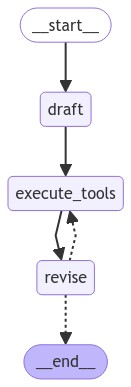

In [64]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [63]:
graph.invoke(
    {
        "messages": [
            HumanMessage(content="How should we handle the climate crisis?"),
        ],
    }
)

Responder::First Attempt 0
Responder::First Response is invalid
Responder::First Attempt 1
Responder::First Response is valid


InvalidUpdateError: Must write to at least one of ['messages']